In [ ]:
from transformers import (
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)

from torch.utils.data import Dataset

import pandas as pd
from sklearn.model_selection import train_test_split

from pathlib import Path
from PIL import Image

In [ ]:
import pandas as pd 


In [ ]:
df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

In [ ]:
images_captions_df = pd.DataFrame({'imgs': [],
                                    'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
         
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)
images_captions_df.head()

In [ ]:
encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p+ images_captions_df['imgs']
images_captions_df.head()


In [ ]:
# maximum length for the captions
max_length = 512
sample = images_captions_df.iloc[99]

# sample image
image = Image.open(sample['imgs']).convert('RGB')
# sample caption
caption = sample['captions']

# apply feature extractor on the sample image
inputs = feature_extractor(images=image, return_tensors='pt')
# apply tokenizer
outputs = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )

In [ ]:
print(f"Inputs:\n{inputs}\nOutputs:\n{outputs}")

In [ ]:
class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = images_captions_df['imgs'].values
        self.captions = images_captions_df['captions'].values

    
    def __getitem__(self, idx):
        # everything to return is stored inside this dict
        inputs = dict()

        # load the image and apply feature_extractor
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        # load the caption and apply tokenizer
        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        # store the inputs and labels in the dict we created
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):
        return len(self.images)

In [ ]:
# train_df, test_df = train_test_split(images_captions_df, test_size=0.20, shuffle=True, random_state=42)

train_,test_df =train_test_split(images_captions_df, test_size=0.10, shuffle=True, random_state=42)

In [ ]:
print(len(train_))
# print(len(val_df))
print(len(test_df))

In [ ]:
train_df,val_df =train_test_split(train_, test_size=0.10, shuffle=True, random_state=42)

In [ ]:
print(len(train_df))
print(len(val_df))
print(len(test_df))


In [ ]:
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
val_ds = LoadDataset(val_df)

In [ ]:
test_df.head()

In [ ]:
next(iter(test_ds))
# next(iter(val_ds))

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, 
    decoder_checkpoint
)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size
model.config.num_beams = 4

In [ ]:
batch = next(iter(train_ds))

model(pixel_values=batch['pixel_values'].unsqueeze(0), labels=batch['labels'].unsqueeze(0))

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator", # name of the directory to store training outputs
    evaluation_strategy="epoch",          # evaluate after each epoch
    per_device_train_batch_size=8,        # batch size during training
    per_device_eval_batch_size=8,         # batch size during evaluation
    learning_rate=5e-5,
    weight_decay=0.01,                    # weight decay for AdamW optimizer
    num_train_epochs=5,                   # number of epochs to train
    save_strategy='epoch',                # save checkpoints after each epoch
    report_to='none',                     # prevents logging to wandb, mlflow...
)

trainer = Seq2SeqTrainer(
    model=model, 
    tokenizer=feature_extractor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

In [ ]:
trainer.train()

### Save Model

In [ ]:
import torch

In [ ]:
FILE = '/kaggle/working/model.pth'

In [ ]:
torch.save(model,FILE)

In [ ]:
loaded_mode = torch.load(FILE)

In [ ]:
loaded_mode.eval()

In [ ]:
# torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# model.load_state_dict(torch.load('model_weights.pth'))


In [ ]:
# model.eval()

### Inference

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
inputs = val_ds[43]['pixel_values']
# model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = loaded_mode.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=512
        )


plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
print(decoded_out)


### Show Original and Actual Imgs 

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have a loop 
for idx in range(40, 50):
    inputs = val_ds[idx]['pixel_values']
    with torch.no_grad():
        # Model prediction 
        out = loaded_mode.generate(
            inputs.unsqueeze(0).to('cuda'),  # Move inputs to GPU
            num_beams=4,
            max_length=512
        )

    # Convert token ids to string format
    decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

    # Display the result
    print(f"Prediction for index {idx}: {decoded_out}")

    # Display the image
    plt.figure()
    plt.axis('off')
    plt.imshow(torch.permute(inputs, (1, 2, 0)))
    plt.show()

    print("\n\nActual Image and Text\n\n")
    # Display the text
    labels_tensor = val_ds[idx]['labels']

    decoded_out = tokenizer.decode(labels_tensor, skip_special_tokens=True)

    print(decoded_out)

    # Display actual image
    inputs = val_ds[idx]['pixel_values']

    # Convert the PyTorch tensor to a NumPy array
    image_array = inputs.permute(1, 2, 0).numpy()
    # Display the image using matplotlib
    plt.figure()
    plt.axis('off')
    plt.imshow(image_array)
    plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import torch
# from torchvision import transforms

# # Assuming you have a loop 
# for idx in range(40, 45):
#     inputs = val_ds[idx]['pixel_values']
    
#     # Retrieve corresponding image from test_df
#     actual_image = val_df.iloc[idx]['imgs'] 
#     caption_actual_text =val_df.iloc[idx]['captions']
#     # Load the image using PIL
#     image = Image.open(actual_image).convert("RGB")

#     # Define the transformation to convert the image to a PyTorch tensor
#     transform = transforms.ToTensor()

#     # Apply the transformation
#     tensor_image = transform(image)
    
#     model.eval()
#     with torch.no_grad():
#         # Uncomment the below line if feature extractor is not applied to the image already
#         # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

#         # Model prediction 
#         out = model.generate(
#             inputs.unsqueeze(0).to('cuda'),  # Move inputs to GPU
#             num_beams=4,
#             # max_length=17
#         )

#     # Convert token ids to string format
#     decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
#     print("************Predicted Img with caption*********\n")
#     # Display the result
#     print(f"Prediction for index {idx}: {decoded_out}")
#     plt.figure()
#     plt.axis('off')
#     plt.imshow(torch.permute(inputs, (1, 2, 0)))
#     plt.show()
    
#     # Display the actual image
#     print("************Actual Img with caption*********\n")
#     plt.figure()
#     plt.axis('off')
#     plt.imshow(torch.permute(tensor_image, (1, 2, 0)))
#     plt.show()
#     print(caption_actual_text)
#     print("\n\n")

### Compute the BLEU score

In [ ]:
import tqdm 
predicted_captions = [] 
for i in tqdm.tqdm( val_df['imgs']):
    
    img =  Image.open(i).convert("RGB")
    caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0],skip_special_tokens=True)
    predicted_captions.append(caption)
print(len(predicted_captions))


In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Assuming you have a list of predicted captions and a list of ground truth captions
generated_captions = predicted_captions
ground_truth_captions = val_df['captions'].values
# Convert the caption lists into the format expected by nltk
ground_truth_captions = [[caption.split() for caption in captions] for captions in ground_truth_captions]
generated_captions = [caption.split() for caption in generated_captions]


# Define the smoothing function to use
smoothie = SmoothingFunction().method4

# Compute the BLEU score with smoothing
weights = (0.25, 0.25, 0.25, 0.25)  # equal weights for 1-4 gram BLEU scores
score = corpus_bleu(ground_truth_captions, predicted_captions,weights =weights)
print(f'The BELU Score Is: {score}')

### Save Model in .h5 Foramt

In [ ]:
# import h5py
# import os
# from pathlib import Path

# # Convert PyTorch model parameters to NumPy arrays
# model_dict = {key: value.cpu().numpy() for key, value in loaded_mode.state_dict().items()}

# # Specify the directory path
# directory_path = '/kaggle/working/model_weight_to_h5.pth/'

# # Create the directory if it doesn't exist
# Path(directory_path).mkdir(parents=True, exist_ok=True)

# # Save the parameters using h5py
# h5_file_path = os.path.join(directory_path, 'model.h5')
# with h5py.File(h5_file_path, 'w') as hf:
#     for key, value in model_dict.items():
#         hf.create_dataset(key, data=value)

# print(f'Model parameters saved to: {h5_file_path}')


In [ ]:
import h5py
import os
from pathlib import Path

# Convert PyTorch model parameters to NumPy arrays
model_dict = {key: value.cpu().numpy() for key, value in loaded_mode.state_dict().items()}

# Specify the directory path
file_path = 'loaded_model.h5'


# Save the parameters using h5py
with h5py.File(file_path, 'w') as hf:
    for key, value in model_dict.items():
        hf.create_dataset(key, data=value)

print(f'Model parameters saved to: {file_path}')


In [ ]:
from IPython.display import FileLink

# Specify the file path in the Kaggle environment
kaggle_file_path = '/kaggle/working/loaded_model.h5'

# Create a downloadable link
FileLink(kaggle_file_path)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training samples: 5239
Test samples: 1230


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.3.crossattention.c_proj.weight', 'h.5.crossattention.c_attn.bias', 'h.10.ln_cross_attn.weight', 'h.1.crossattention.q_attn.bias', 'h.9.ln_cross_attn.bias', 'h.8.ln_cross_attn.weight', 'h.8.crossattention.c_proj.weight', 'h.2.crossattention.c_attn.bias', 'h.4.ln_cross_attn.bias', 'h.8.crossattention.c_attn.bias', 'h.0.ln_cross_attn.weight', 'h.9.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.11.crossattention.c_proj.bias', 'h.5.ln_cross_attn.weight', 'h.4.crossattention.c_proj.weight', 'h.6.crossattention.c_proj.weight', 'h.10.ln_cross_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.7.crossattention.q_attn.bias', 'h.8.crossattention.c_attn.weight', 'h.2.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.weight', 'h.2.crossattention.q_attn.bias', 'h.5.crossattention.c_proj.

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.201000,0.117069
2,0.120500,0.102166
3,0.105700,0.093418
4,0.088300,0.088847
5,0.082600,0.087482


Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


  0%|          | 0/1230 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1230/1230 [08:52<00:00,  2.31it/s]
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The BLEU Score Is: 0.6880535548679273
Model parameters saved to: 1loaded_model.h5


/kaggle/working/1loaded_model.h5

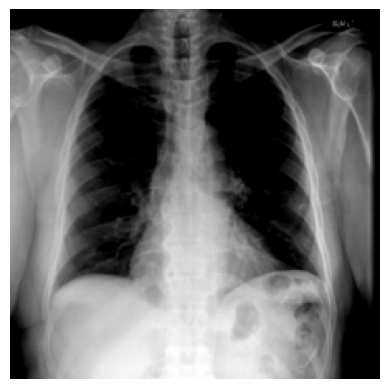

In [1]:
from transformers import (
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)

from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import torch
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import tqdm
from IPython.display import FileLink
import h5py
import os

# Load datasets
df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Create image-caption pairs
images_captions_df = pd.DataFrame({'imgs': [], 'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] == uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)

# Add full image path
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p + images_captions_df['imgs']

# Split into train (5239) and test (1230)
train_df, test_df = train_test_split(images_captions_df, test_size=1230, train_size=5239, shuffle=True, random_state=42)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Set up model components
encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"
max_length = 512

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

# Dataset class
class LoadDataset(Dataset):
    def __init__(self, df):  # Fixed: double underscores
        self.images = df['imgs'].values
        self.captions = df['captions'].values
    
    def __getitem__(self, idx):  # Fixed: double underscores
        inputs = dict()
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):  # Fixed: double underscores
        return len(self.images)

# Create datasets
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)

# Initialize model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, 
    decoder_checkpoint
)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.num_beams = 4

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    save_strategy='epoch',
    report_to='none',
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model, 
    tokenizer=feature_extractor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

# Train the model
trainer.train()

# Save the model
FILE = '/kaggle/working/1model.pth'
torch.save(model, FILE)
loaded_model = torch.load(FILE)
loaded_model.eval()

# Inference example
inputs = test_ds[0]['pixel_values']
with torch.no_grad():
    out = loaded_model.generate(
        inputs.unsqueeze(0).to('cuda'),
        num_beams=4,
        max_length=512
    )

plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)))
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
print(decoded_out)

# Generate predictions for BLEU score calculation
predicted_captions = []
for i in tqdm.tqdm(test_df['imgs']):
    img = Image.open(i).convert("RGB")
    caption = tokenizer.decode(loaded_model.generate(
        feature_extractor(img, return_tensors="pt").pixel_values.to("cuda")
    )[0], skip_special_tokens=True)
    predicted_captions.append(caption)

# Calculate BLEU score
ground_truth_captions = test_df['captions'].values
ground_truth_captions = [[caption.split() for caption in captions] for captions in ground_truth_captions]
generated_captions = [caption.split() for caption in predicted_captions]
smoothie = SmoothingFunction().method4
weights = (0.25, 0.25, 0.25, 0.25)
score = corpus_bleu(ground_truth_captions, predicted_captions, weights=weights)
print(f'The BLEU Score Is: {score}')

# Save model in HDF5 format
model_dict = {key: value.cpu().numpy() for key, value in loaded_model.state_dict().items()}
file_path = '1loaded_model.h5'
with h5py.File(file_path, 'w') as hf:
    for key, value in model_dict.items():
        hf.create_dataset(key, data=value)
print(f'Model parameters saved to: {file_path}')

# Create downloadable link
FileLink(file_path)

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
from transformers import (
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import tqdm
from IPython.display import FileLink
import h5py
import os

# Load datasets
df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Create image-caption pairs
images_captions_df = pd.DataFrame({'imgs': [], 'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] == uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)

# Add full image path
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p + images_captions_df['imgs']

# Split into train (5239) and test (1230)
train_df, test_df = train_test_split(images_captions_df, test_size=1230, train_size=5239, shuffle=True, random_state=42)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Set up model components
encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"
max_length = 512

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

# Dataset class
class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = df['imgs'].values
        self.captions = df['captions'].values
    
    def __getitem__(self, idx):
        inputs = dict()
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):
        return len(self.images)

# Create datasets
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)

# Initialize model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint, 
    decoder_checkpoint
)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.num_beams = 4

# Training arguments (optimized for TPU)
training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,  # Larger batch size for TPU
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    save_strategy='epoch',
    report_to='none',
    dataloader_drop_last=True,  # Avoid uneven batches on TPU
    tpu_num_cores=8,  # Use all 8 TPU cores
)

# Trainer with XLA support
trainer = Seq2SeqTrainer(
    model=model, 
    tokenizer=feature_extractor, 
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

# Train the model on TPU
def train_fn():
    trainer.train()

# Launch TPU training
xmp.spawn(train_fn, args=(), nprocs=8)  # Use all 8 TPU cores

# Save the model (after training)
FILE = '/kaggle/working/1model.pth'
torch.save(model.state_dict(), FILE)  # Save only weights for TPU compatibility

# Inference example (on CPU/GPU)
loaded_model = VisionEncoderDecoderModel.from_pretrained(encoder_checkpoint, decoder_checkpoint)
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.eval()

inputs = test_ds[0]['pixel_values']
with torch.no_grad():
    out = loaded_model.generate(
        inputs.unsqueeze(0),
        num_beams=4,
        max_length=512
    )

plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)))
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
print(decoded_out)

# BLEU score calculation (same as before)
predicted_captions = []
for i in tqdm.tqdm(test_df['imgs']):
    img = Image.open(i).convert("RGB")
    caption = tokenizer.decode(loaded_model.generate(
        feature_extractor(img, return_tensors="pt").pixel_values
    )[0], skip_special_tokens=True)
    predicted_captions.append(caption)

ground_truth_captions = test_df['captions'].values
ground_truth_captions = [[caption.split() for caption in captions] for captions in ground_truth_captions]
generated_captions = [caption.split() for caption in predicted_captions]
smoothie = SmoothingFunction().method4
weights = (0.25, 0.25, 0.25, 0.25)
score = corpus_bleu(ground_truth_captions, predicted_captions, weights=weights)
print(f'The BLEU Score Is: {score}')

# Save model in HDF5 format
model_dict = {key: value.cpu().numpy() for key, value in loaded_model.state_dict().items()}
file_path = '1loaded_model.h5'
with h5py.File(file_path, 'w') as hf:
    for key, value in model_dict.items():
        hf.create_dataset(key, data=value)
print(f'Model parameters saved to: {file_path}')

FileLink(file_path)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch_xla.core.xla_model as xm
device = xm.xla_device()
print(f"Using device: {device}")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: xla:0


E0000 00:00:1742960360.797031     436 common_lib.cc:822] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`=local.
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:539


In [2]:
!zip -r file.zip /kaggle/working

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/1model.pth (deflated 10%)
  adding: kaggle/working/image-caption-generator/ (stored 0%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/ (stored 0%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/generation_config.json (deflated 24%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/model.safetensors (deflated 7%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/config.json (deflated 75%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/training_args.bin (deflated 50%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/trainer_state.json (deflated 53%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/optimizer.pt (deflated 8%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/scheduler.pt (deflated 49%)
  adding: kaggle/working/image-caption-generator/checkpoint-655/preprocessor_config.json (deflated 46%)
 

In [3]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip